In [24]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

In [26]:
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

def meanSquaredError(y):
  return mean_squared_error(y, [np.mean(y)] * len(y))

In [27]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [28]:
def bootstrap_sample(X, y):
    num_samples = X.shape[0]
    indexes = np.random.choice(num_samples, num_samples, replace=True)
    return X[indexes], y[indexes]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [29]:
class DecisionTree(BaseEstimator):
  def __init__(self, min_num_samples_split=5, max_tree_depth=100, num_features=None, predict_labels=True):
    self.min_num_samples_split = min_num_samples_split
    self.max_tree_depth = max_tree_depth
    self.num_features = num_features
    self.predict_labels = predict_labels
    self.root = None

  def fit(self, X, y):
    self.num_features = X.shape[1] if not self.num_features else min(self.num_features, X.shape[1])
    self.root = self.grow_tree(X, y)

  def grow_tree(self, X, y, depth=0):
    num_samples, num_features = X.shape
    num_labels = len(np.unique(y))

    # Stopping criteria
    if (depth >= self.max_tree_depth or num_labels == 1 or num_samples < self.min_num_samples_split):
      if self.predict_labels:
        leaf_value = most_common_label(y)
      else:
        leaf_value = np.mean(y)
      return Node(value=leaf_value)

    feature_indexes = np.random.choice(num_features, self.num_features, replace=False)

    best_feature, best_threshold = self.get_best_split(X, y, feature_indexes)

    # Grow the tree from the split
    left_idxs, right_idxs = self.split(X[:, best_feature], best_threshold)
    left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
    right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

    return Node(best_feature, best_threshold, left, right)

  def get_best_split(self, X, y, feature_indexes):
    best_gini_gain = 0
    split_index, split_threshold = None, None
    for feature_index in feature_indexes:
      X_column = X[:, feature_index]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self.gini_gain(y, X_column, threshold)

        if gain > best_gini_gain:
          best_gini_gain = gain
          split_index = feature_index
          split_threshold = threshold

    return split_index, split_threshold

  def gini_gain(self, y, X_column, split_threshold):
    if self.predict_labels:
      impurity_func = giniImpurity
    else:
      impurity_func = meanSquaredError

    parent_impurity = impurity_func(y)

    # generate split
    left_idxs, right_idxs = self.split(X_column, split_threshold)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted average for the children
    n = len(y)
    num_left, num_right = len(left_idxs), len(right_idxs)
    left_impurity, right_impurity = impurity_func(y[left_idxs]), impurity_func(y[right_idxs])
    child_impurity = (num_left / n) * left_impurity + (num_right / n) * right_impurity

    # gini gain is difference in loss before vs. after split
    gain = parent_impurity - child_impurity
    return gain

  def split(self, X_column, split_threshold):
    left_idxs = np.argwhere(X_column <= split_threshold).flatten()
    right_idxs = np.argwhere(X_column > split_threshold).flatten()
    return left_idxs, right_idxs

  def predict(self, X):
    return np.array([self.traverse_tree(x, self.root) for x in X])

  def traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self.traverse_tree(x, node.left)
    return self.traverse_tree(x, node.right)

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class GradientBooster(BaseEstimator):
    def __init__(self,
                 num_estimators=10,
                 min_num_samples_split=5,
                 max_tree_depth=3):
        self.num_estimators = num_estimators
        self.min_num_samples_split = min_num_samples_split
        self.max_tree_depth = max_tree_depth
        self.learning_rate = 0.2
        self.initial_prediction = None
        self.trees = []

    def fit(self, X, y):
        self.initial_prediction = np.mean(y)
        print(f"Initial prediction: {self.initial_prediction}")

        predictions = np.ones_like(y) * self.initial_prediction
        residuals = y - sigmoid(predictions)
        print(f"Residuals: {residuals}")

        for _ in range(self.num_estimators):
            tree = DecisionTree(min_num_samples_split=self.min_num_samples_split,
                                max_tree_depth=self.max_tree_depth,
                                predict_labels=False)
            tree.fit(X, residuals)
            self.trees.append(tree)

            predictions = tree.predict(X) * self.learning_rate
            residuals = y - sigmoid(predictions)
            print(f"Residuals: {residuals}")

    def predict_proba(self, X):
        final_prediction = np.ones(X.shape[0]) * self.initial_prediction

        for tree in self.trees:
            final_prediction += self.learning_rate * tree.predict(X)

        return sigmoid(final_prediction)

    def predict(self, X):
        prob = self.predict_proba(X)
        return (prob > 0.5).astype(int)

In [31]:
# Mount Google drive and copy kaggle.json to local disk

from google.colab import drive
drive.mount('mount')

!cp mount/MyDrive/kaggle.json .

Drive already mounted at mount; to attempt to forcibly remount, call drive.mount("mount", force_remount=True).


In [32]:
!KAGGLE_CONFIG_DIR=$(pwd) kaggle datasets download rabieelkharoua/students-performance-dataset

Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
students-performance-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
!unzip -o students-performance-dataset.zip -d students-performance-dataset

Archive:  students-performance-dataset.zip
  inflating: students-performance-dataset/Student_performance_data _.csv  


In [34]:
student_performance_df_orig = pd.read_csv('students-performance-dataset/Student_performance_data _.csv')

In [35]:
student_performance_df = student_performance_df_orig.drop(['StudentID', 'GradeClass', 'GPA'], axis=1)
student_performance_df = pd.DataFrame(standard_scaler.fit_transform(student_performance_df), columns=student_performance_df.columns)
student_performance_df

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
0,0.472919,0.978492,-0.853391,0.253711,1.780336,-0.890822,1.522371,-0.108744,-0.788476,-0.660132,2.019544,-0.431866
1,1.362944,-1.021981,-0.853391,-0.746087,0.997376,-1.717694,-0.656870,-0.999551,-0.788476,-0.660132,-0.495161,-0.431866
2,-1.307132,-1.021981,1.091641,1.253509,-0.984045,1.353542,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,-0.431866
3,0.472919,0.978492,-0.853391,1.253509,0.045445,-0.063951,-0.656870,0.782063,1.268269,-0.660132,-0.495161,-0.431866
4,0.472919,0.978492,-0.853391,0.253711,-0.902311,0.290422,1.522371,0.782063,-0.788476,-0.660132,-0.495161,-0.431866
...,...,...,...,...,...,...,...,...,...,...,...,...
2387,1.362944,0.978492,-0.853391,1.253509,0.160762,-1.481445,-0.656870,1.672869,1.268269,-0.660132,-0.495161,-0.431866
2388,0.472919,-1.021981,-0.853391,-0.746087,-0.387285,-1.245196,1.522371,1.672869,-0.788476,1.514848,-0.495161,-0.431866
2389,-0.417106,0.978492,-0.853391,0.253711,-0.524895,0.644796,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,2.315535
2390,-0.417106,0.978492,0.119125,-1.745885,0.467950,0.290422,-0.656870,-0.108744,-0.788476,1.514848,2.019544,-0.431866


In [36]:
student_performance_target = np.array(student_performance_df_orig['GradeClass'].map(lambda gradeclass: 0 if gradeclass <= 3.0 else 1), dtype=np.int8)
student_performance_target

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [37]:
from sklearn.model_selection import cross_val_score

gradient_booster = GradientBooster(num_estimators=3)

cross_val_score(gradient_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial prediction: 0.4891304347826087
Residuals: [-0.61990156  0.38009844  0.38009844 ... -0.61990156 -0.61990156
 -0.61990156]
Residuals: [-0.47183963  0.49305583  0.49305583 ... -0.50694417 -0.50694417
 -0.49926808]
Residuals: [-0.47893372  0.48741017  0.48741017 ... -0.51258983 -0.51258983
 -0.50529956]
Residuals: [-0.47884504  0.48769228  0.48769228 ... -0.51230772 -0.51230772
 -0.50499801]
Initial prediction: 0.5234113712374582
Residuals: [-0.62794511 -0.62794511  0.37205489 ...  0.37205489 -0.62794511
 -0.62794511]
Residuals: [-0.46900749 -0.46900749  0.48164532 ...  0.48544178 -0.46900749
 -0.46900749]
Residuals: [-0.47668975 -0.47668975  0.4761756  ...  0.47977935 -0.48191466
 -0.47668975]
Residuals: [-0.47652994 -0.47652994  0.47644847 ...  0.48006201 -0.47652994
 -0.47652994]


array([0.52341137, 0.48913043])

In [38]:
from sklearn.model_selection import cross_val_score

gradient_booster = GradientBooster(num_estimators=3, max_tree_depth=10)

cross_val_score(gradient_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial prediction: 0.4891304347826087
Residuals: [-0.61990156  0.38009844  0.38009844 ... -0.61990156 -0.61990156
 -0.61990156]
Residuals: [-0.46904456  0.48342051  0.48100423 ... -0.50650455 -0.46904456
 -0.46904456]
Residuals: [-0.47656496  0.47826204  0.47596832 ... -0.51294125 -0.47656496
 -0.47656496]
Residuals: [-0.47618977  0.47851948  0.47621954 ... -0.51175012 -0.47618977
 -0.47618977]
Initial prediction: 0.5234113712374582
Residuals: [-0.62794511 -0.62794511  0.37205489 ...  0.37205489 -0.62794511
 -0.62794511]
Residuals: [-0.46864395 -0.46864395  0.48140583 ...  0.48140583 -0.50610244
 -0.46864395]
Residuals: [-0.47658494 -0.47658494  0.47594829 ...  0.47594829 -0.51219246
 -0.47658494]
Residuals: [-0.47618878 -0.47618878  0.47622054 ...  0.47622054 -0.51188814
 -0.47618878]


array([0.52341137, 0.48913043])

In [39]:
from sklearn.model_selection import cross_val_score

gradient_booster = GradientBooster(num_estimators=7)

cross_val_score(gradient_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial prediction: 0.4891304347826087
Residuals: [-0.61990156  0.38009844  0.38009844 ... -0.61990156 -0.61990156
 -0.61990156]
Residuals: [-0.47183963  0.49305583  0.49305583 ... -0.50694417 -0.50694417
 -0.49926808]
Residuals: [-0.47893372  0.48741017  0.48741017 ... -0.51258983 -0.51258983
 -0.50529956]
Residuals: [-0.47884504  0.48769228  0.48769228 ... -0.51230772 -0.51230772
 -0.50499801]
Residuals: [-0.47858409  0.48767818  0.48767818 ... -0.51232182 -0.51232182
 -0.50501309]
Residuals: [-0.47886245  0.48767889  0.48767889 ... -0.51232111 -0.51232111
 -0.50501234]
Residuals: [-0.47858322  0.48767885  0.48767885 ... -0.51232115 -0.51232115
 -0.50501237]
Residuals: [-0.47886249  0.48767885  0.48767885 ... -0.51232115 -0.51232115
 -0.50501237]
Initial prediction: 0.5234113712374582
Residuals: [-0.62794511 -0.62794511  0.37205489 ...  0.37205489 -0.62794511
 -0.62794511]
Residuals: [-0.46900749 -0.46900749  0.48164532 ...  0.48544178 -0.46900749
 -0.46900749]
Residuals: [-0.4766897

array([0.85953177, 0.79598662])

In [40]:
from sklearn.model_selection import cross_val_score

gradient_booster = GradientBooster(num_estimators=7, max_tree_depth=10)

cross_val_score(gradient_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial prediction: 0.4891304347826087
Residuals: [-0.61990156  0.38009844  0.38009844 ... -0.61990156 -0.61990156
 -0.61990156]
Residuals: [-0.46904456  0.48342051  0.48100423 ... -0.50650455 -0.46904456
 -0.46904456]
Residuals: [-0.47656496  0.47826204  0.47596832 ... -0.51294125 -0.47656496
 -0.47656496]
Residuals: [-0.47618977  0.47851948  0.47621954 ... -0.51175012 -0.47618977
 -0.47618977]
Residuals: [-0.47620849  0.47850663  0.47620701 ... -0.51268137 -0.47620849
 -0.47620849]
Residuals: [-0.47620756  0.47850728  0.47620763 ... -0.51176325 -0.47620756
 -0.47620756]
Residuals: [-0.4762076   0.47850724  0.4762076  ... -0.51268071 -0.4762076
 -0.4762076 ]
Residuals: [-0.4762076   0.47850725  0.4762076  ... -0.51176328 -0.4762076
 -0.4762076 ]
Initial prediction: 0.5234113712374582
Residuals: [-0.62794511 -0.62794511  0.37205489 ...  0.37205489 -0.62794511
 -0.62794511]
Residuals: [-0.46864395 -0.46864395  0.48140583 ...  0.48140583 -0.50610244
 -0.46864395]
Residuals: [-0.47658494 

array([0.86371237, 0.81605351])

In [41]:
from sklearn.model_selection import cross_val_predict

student_performance_predicted_target = cross_val_predict(gradient_booster, student_performance_df.values, student_performance_target, cv=2)

Initial prediction: 0.4891304347826087
Residuals: [-0.61990156  0.38009844  0.38009844 ... -0.61990156 -0.61990156
 -0.61990156]
Residuals: [-0.46904456  0.48342051  0.48100423 ... -0.50650455 -0.46904456
 -0.46904456]
Residuals: [-0.47656496  0.47826204  0.47596832 ... -0.51294125 -0.47656496
 -0.47656496]
Residuals: [-0.47618977  0.47851948  0.47621954 ... -0.51175012 -0.47618977
 -0.47618977]
Residuals: [-0.47620849  0.47850663  0.47620701 ... -0.51268137 -0.47620849
 -0.47620849]
Residuals: [-0.47620756  0.47850728  0.47620763 ... -0.51176325 -0.47620756
 -0.47620756]
Residuals: [-0.4762076   0.47850724  0.4762076  ... -0.51268071 -0.4762076
 -0.4762076 ]
Residuals: [-0.4762076   0.47850725  0.4762076  ... -0.51176328 -0.4762076
 -0.4762076 ]
Initial prediction: 0.5234113712374582
Residuals: [-0.62794511 -0.62794511  0.37205489 ...  0.37205489 -0.62794511
 -0.62794511]
Residuals: [-0.46864395 -0.46864395  0.48140583 ...  0.48140583 -0.50610244
 -0.46864395]
Residuals: [-0.47658494 

In [42]:
student_performance_predicted_target

array([0, 0, 1, ..., 1, 1, 0])

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(student_performance_target, student_performance_predicted_target)

array([[ 911,  270],
       [ 104, 1107]])

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8501422042695524

In [46]:
recall_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8436454849498328

In [47]:
f1_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8427503717149938

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(student_performance_target, student_performance_predicted_target)

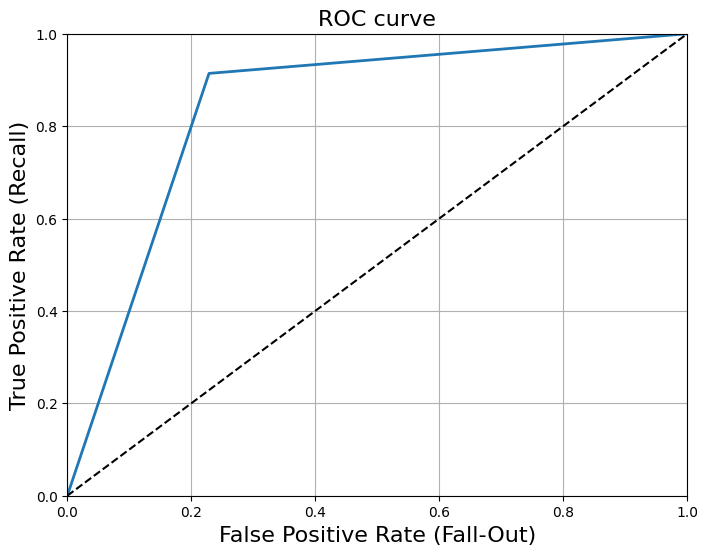

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(student_performance_target, student_performance_predicted_target)

0.8427503739011082